# Architecture 1b - Multiple column, multiple timestep forecasting, denoised data without S4 and S2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *
# from Data_sorting import Data_formatter_cycles

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_27168\1826588735.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [22]:
data = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/Data formatting/Dataset_scaled_denoised.xlsx')
data = data[data['I'] == 1.6]
X = data.iloc[:,:9]
X = X.drop('S4_cur', axis = 1)
X = X.drop('S1_cur', axis = 1)
X = X.drop('I', axis = 1)
X = X.drop('Sp_cur', axis = 1)

y = X.iloc[2:,:]
X = X.iloc[1:-1,:]

In [23]:
print(X)

          S8_cur    S2_cur     V_cur        EH        EL
1       2.914558 -0.929154  3.965686  3.914506  4.072668
2       2.914450 -0.929154  3.953539  3.902619  4.059976
3       2.914342 -0.929154  3.941755  3.891043  4.047754
4       2.914234 -0.929154  3.930271  3.879762  4.035847
5       2.914126 -0.929154  3.919073  3.868761  4.024235
...          ...       ...       ...       ...       ...
144007 -0.715584  2.665348 -0.871372 -0.874460 -0.864714
144008 -0.715584  2.665422 -0.871377 -0.874464 -0.864718
144009 -0.715584  2.665497 -0.871381 -0.874468 -0.864723
144010 -0.715584  2.665571 -0.871385 -0.874473 -0.864727
144011 -0.715584  2.665645 -0.871390 -0.874477 -0.864732

[144011 rows x 5 columns]


In [24]:
X_numpy = X.values
y_numpy = y.values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42)

In [58]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim = 5))
model.add(Dense(20, activation='relu'))
# model.add(Dense(12,activation = 'relu'))
# model.add(Dense(24,activation = 'relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='linear'))  # Output layer with a multiple neurons

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
1801/1801 [==============================] - 2s 899us/step - loss: 0.0276
Epoch 2/100
1801/1801 [==============================] - 2s 880us/step - loss: 9.3945e-05
Epoch 3/100
1801/1801 [==============================] - 2s 933us/step - loss: 6.5817e-05
Epoch 4/100
1801/1801 [==============================] - 2s 1ms/step - loss: 6.4868e-05
Epoch 5/100
1801/1801 [==============================] - 2s 1ms/step - loss: 6.2808e-05
Epoch 6/100
1801/1801 [==============================] - 2s 881us/step - loss: 6.3389e-05
Epoch 7/100
1801/1801 [==============================] - 2s 1ms/step - loss: 5.8397e-05
Epoch 8/100
1801/1801 [==============================] - 2s 949us/step - loss: 5.5861e-05
Epoch 9/100
1801/1801 [==============================] - 2s 1ms/step - loss: 6.0841e-05
Epoch 10/100
1801/1801 [==============================] - 2s 1ms/step - loss: 5.8172e-05
Epoch 11/100
1801/1801 [==============================] - 2s 1ms/step - loss: 5.3591e-05
Epoch 12/100
1801/1801 [

In [59]:
# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {mse}")

901/901 [==============================] - 1s 820us/step - loss: 3.4976e-07
Mean Squared Error on Test Set: 3.4976480378645647e-07


In [60]:
threshold = 0.005
errors = 0

# Define function for linear extrapolation
def linear_extrapolation(prev_array1, prev_array2):
    # Calculate the slope for each element
    slopes = prev_array2 - prev_array1
    # Extrapolate values for the third array
    extrapolated_array = prev_array2 + slopes/2
    return extrapolated_array





no_predictions = 1000
start = 1500
input = np.array([X_numpy[start]])
output = []

scale = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/Data formatting/Scales_denoised.xlsx')

# print(input)

for i in range(no_predictions):
    
    next_prediction_array = model.predict(input)

    # print(next_prediction_array)


    if i > 2 and np.any(np.abs(np.array(next_prediction_array[0]) - np.array(output[i-1])) > threshold):
        linear_array = linear_extrapolation(np.array(output[i-2]), np.array(output[i-1]))
        errors += 1
        output.append(linear_array)
        print(linear_array)
        input = next_prediction_array
        # print(input)


    else:
        output.append(next_prediction_array[0])
        input = next_prediction_array


    if errors >= 20:
        no_predictions = i + 1
        break

1/1 [==============================] - 0s 22ms/step


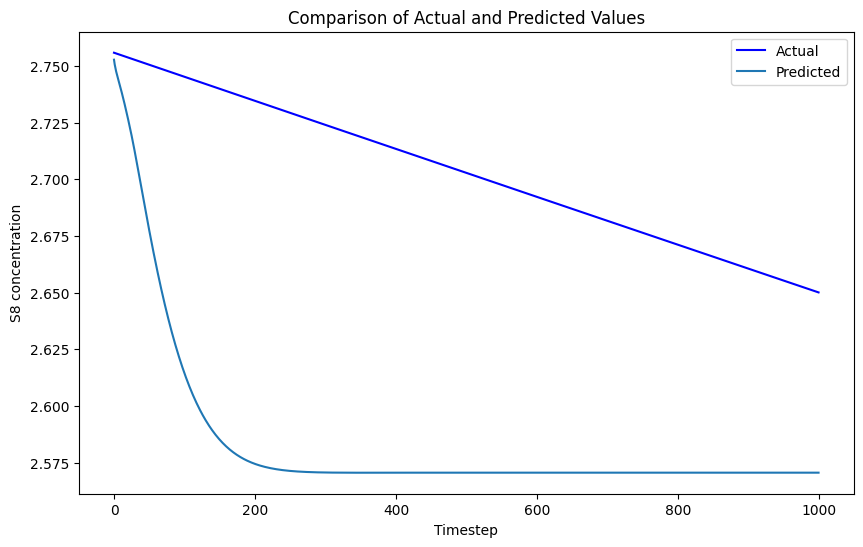

1000


In [52]:
plot_actual = []

for j in range(no_predictions):
    plot_actual.append(X_numpy[start + j])

# Extracting the first value from each entry in plot_actual
first_values_actual = [item[0] for item in plot_actual]

# Extracting the first value from each predicted array in output
first_values_predicted = [item[0] for item in output]

# Create a range for the x-axis
x_range = range(len(first_values_actual))


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_range, first_values_actual, label='Actual', c = 'b')
plt.plot(x_range, first_values_predicted, label='Predicted')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Timestep')
plt.ylabel('S8 concentration')
plt.legend()

# Show plot
plt.show()


print(len(first_values_predicted))

In [61]:
threshold = 0.005
errors = 0

# Define function for linear extrapolation
def linear_extrapolation(prev_array1, prev_array2):
    # Calculate the slope for each element
    slopes = prev_array2 - prev_array1
    # Extrapolate values for the third array
    extrapolated_array = prev_array2 + slopes/2
    return extrapolated_array





no_predictions = 1000
start = 1500
input = np.array([X_numpy[start]])
output = []

scale = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/Data formatting/Scales_denoised.xlsx')

# print(input)

for i in range(no_predictions):
    
    next_prediction_array = model.predict(input)

    # print(next_prediction_array)


    if i > 2 and np.any(np.abs(np.array(next_prediction_array[0]) - np.array(output[i-1])) > threshold):
        next_prediction_array = linear_extrapolation(np.array(output[i-2]), np.array(output[i-1]))
        errors += 1
        output.append(next_prediction_array)
        print(next_prediction_array)
        input = next_prediction_array
        # print(input)


    else:
        output.append(next_prediction_array[0])
        input = next_prediction_array


    if errors >= 20:
        no_predictions = i + 1
        break

1/1 [==============================] - 0s 19ms/step


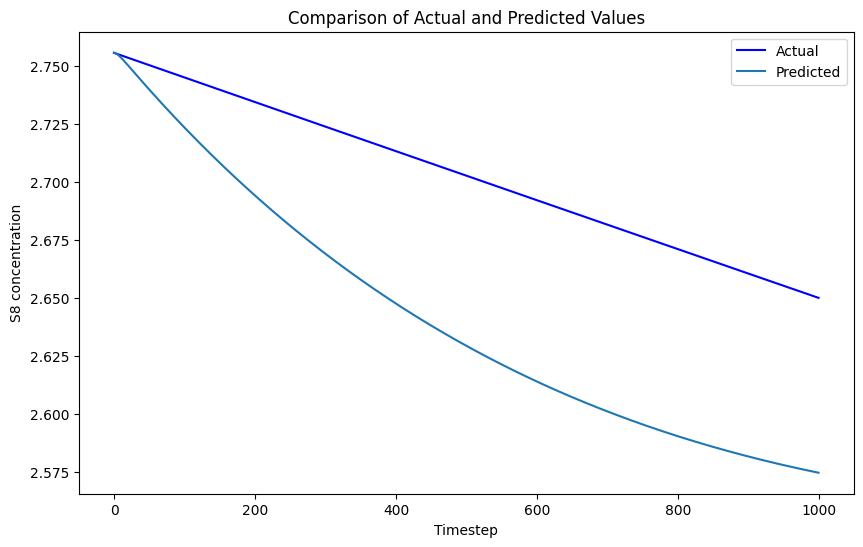

1000


In [62]:
plot_actual = []

for j in range(no_predictions):
    plot_actual.append(X_numpy[start + j])

# Extracting the first value from each entry in plot_actual
first_values_actual = [item[0] for item in plot_actual]

# Extracting the first value from each predicted array in output
first_values_predicted = [item[0] for item in output]

# Create a range for the x-axis
x_range = range(len(first_values_actual))


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_range, first_values_actual, label='Actual', c = 'b')
plt.plot(x_range, first_values_predicted, label='Predicted')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Timestep')
plt.ylabel('S8 concentration')
plt.legend()

# Show plot
plt.show()


print(len(first_values_predicted))